# Final assignment Unsupervised Learning

## Background information

This dataset contains coordinates from markers of skull features from different species of primates. Utilizing unsupervised learning techniques, these will be clustered into groups by species.

## Loading in the data

In [2]:
# Loading in necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
from scipy import stats
from sklearn import metrics
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer

In [2]:
df = pd.read_csv('data/primates-morphology.csv')
# remove unnamed column, it just contains 165 unique values and seem to be an index
df.drop('Unnamed: 0', axis=1, inplace=True)
df

0           1          2          3          4          5  \
0    133.426742 -101.627603  21.125902 -11.518251   4.621089  -1.519551   
1    145.344740 -108.229812  21.121390 -14.982879   2.299335  -2.354040   
2    137.773342 -107.162743  18.232497 -17.116294   3.016809  -5.295234   
3    141.523739 -107.436626  17.448083 -16.861469   3.382894  -1.071286   
4    142.357906  -97.195294  10.511391  -6.520641   3.555506   1.652390   
..          ...         ...        ...        ...        ...        ...   
160  -91.085462  -46.160638  86.488654  16.969797   8.581993  -8.889106   
161  -91.489354  -39.614165  87.430951  20.871706  11.444575  -6.707486   
162  -90.204104  -40.985982  83.286250  19.714259  10.448984 -10.269775   
163  -90.248202  -50.111180  77.285086  19.578454   5.634918 -13.863556   
164  -88.663448  -43.835382  74.681197  19.086880   9.755993  -9.499983   

            6         7         8         9  ...        25        26  \
0    0.583410 -7.182875  1.410030  0.216411  ... -0.301822 -0.433051   
1    0.431199 -5.266930 -1.424469 -1.451953  ...  0.215340 -0.299550   
2    1.716895 -1.668914 -1.917478  0.601120  ... -0.481468 -0.243025   
3    1.768891 -2.735232 -1.136700 -2.706925  ...  0.586941 -0.043639   
4   -0.655919 -5.373075 -1.466841 -2.626544  ...  0.653851  0.718319   
..        ...       ...       ...       ...  ...       ...       ...   
160  3.806365 -2.572926 -1.852834 -0.197013  ...  0.360452  0.513323   
161  1.910320 -5.616304 -3.878495 -0.037360  ... -0.368755 -0.173323   
162  4.749293 -2.725633 -1.577457  2.706787  ... -0.033229  0.434486   
163  1.840409 -0.507864 -1.227452  0.595468  ...  0.125275 -0.018511   
164  2.948722 -2.992005 -0.666312  0.333317  ...  0.141954 -0.947492   

           27        28        29  Abbreviation      Genus    Species  Sex  \
0    0.037651 -0.279618 -0.421040            Ph  Presbytis      hosei    U   
1    0.709472  0.876382 -0.150133            Ph  Presbytis      hosei    F   
2   -0.537644 -0.140292  0.082158            Pr  Presbytis  rubicunda    U   
3   -0.518699 -1.051100  0.542354            Pr  Presbytis  rubicunda    M   
4    0.798722 -0.396749  0.844772            Pr  Presbytis  rubicunda    F   
..        ...       ...       ...           ...        ...        ...  ...   
160  0.043604  0.294724 -0.003514            Hl  Hylobates        lar    F   
161 -0.627292  0.092090  0.444992            Hl  Hylobates        lar    F   
162 -0.158110 -0.416191  0.160474            Hl  Hylobates        lar    F   
163  0.080169 -0.235063  0.317110            Hl  Hylobates        lar    F   
164  0.060862 -0.297479  0.723835            Hl  Hylobates        lar    F   

     Age  
0      A  
1      A  
2      A  
3      A  
4      A  
..   ...  
160    A  
161    A  
162    A  
163    A  
164    A  

[165 rows x 35 columns]

The dataset will be split into labels and non-labels. The non labels should allow the model to properly determine the species of the sample. Certain features will be dropped, mostly the metadata. Genus, Abbrev and Species are things that are to be predicted and can be used as labels afterwards to check the models accuracy. Sex and age do not contribute to becoming a different species, thus these will also be dropped.

Note: The labels will not be used in training the model, as it would no longer be unsupervised learning. However, with the labels being known, the accuracy of the model can be verified post hoc using them.

In [3]:
# Separate labels and values
df_vals = df.drop(['Abbreviation', 'Genus', 'Species', 'Sex', 'Age'], axis=1)
df_labels = df['Species']

## Data Exploration

### Missing data

Quickly check if there is any missing data in the dataset

In [4]:
print('There are {:.1f} missing data points'.format(df.isna().sum().sum()))

There are 0.0 missing data points


In [5]:
df.describe()

0           1           2           3           4           5  \
count  165.000000  165.000000  165.000000  165.000000  165.000000  165.000000   
mean     5.537129    1.196007   -0.125596    0.774423   -0.161111   -0.182550   
std     99.061556   69.971050   56.627559   18.591984   11.336600    8.710069   
min   -201.591249 -111.659165 -114.986835  -54.636918  -19.375303  -24.431319   
25%    -58.767559  -44.542377  -45.981261  -12.328664   -7.348686   -5.823589   
50%     -4.994670   18.343281   -2.090244    4.082730   -2.158090   -1.071286   
75%     89.480991   42.633134   32.805157   16.969797    3.716401    5.078963   
max    192.170450  433.444316  142.161119   33.486208   68.005131   21.570367   

                6           7           8           9  ...          20  \
count  165.000000  165.000000  165.000000  165.000000  ...  165.000000   
mean    -0.077955    0.180683    0.132617   -0.030271  ...    0.057334   
std      5.463093    5.214248    4.520787    3.389125  ...    1.254471   
min    -54.611282  -20.855026  -18.487708  -13.764311  ...   -3.793245   
25%     -1.389680   -2.572926   -2.279476   -1.834020  ...   -0.697783   
50%     -0.124301   -0.379776   -0.057433   -0.158941  ...    0.086293   
75%      1.575336    3.017432    3.199454    1.722897  ...    0.784991   
max     18.598186   20.232449   18.859660   11.154277  ...    3.300278   

               21          22          23          24          25          26  \
count  165.000000  165.000000  165.000000  165.000000  165.000000  165.000000   
mean    -0.014223    0.013269   -0.002892    0.005006    0.003208   -0.001137   
std      1.161247    0.971599    0.932425    0.865874    0.750532    0.720479   
min     -2.894577   -3.849517   -1.838070   -2.274559   -2.037714   -2.934118   
25%     -0.739499   -0.482541   -0.585089   -0.587203   -0.413921   -0.411248   
50%     -0.103932    0.123128   -0.072030   -0.018886   -0.023107   -0.022457   
75%      0.633467    0.526249    0.512882    0.621830    0.474782    0.418680   
max      3.376167    3.423704    4.006407    3.131717    2.052453    2.727110   

               27          28          29  
count  165.000000  165.000000  165.000000  
mean    -0.002748   -0.012738   -0.013131  
std      0.484438    0.461879    0.374258  
min     -1.245955   -2.115305   -1.128128  
25%     -0.300449   -0.320591   -0.248282  
50%      0.001251   -0.018000   -0.010527  
75%      0.274560    0.277566    0.268744  
max      1.319978    1.653007    0.844772  

[8 rows x 30 columns]

There range of the data seems to be very different per feature. Most likely the data will need to be scaled.

### Data distribution

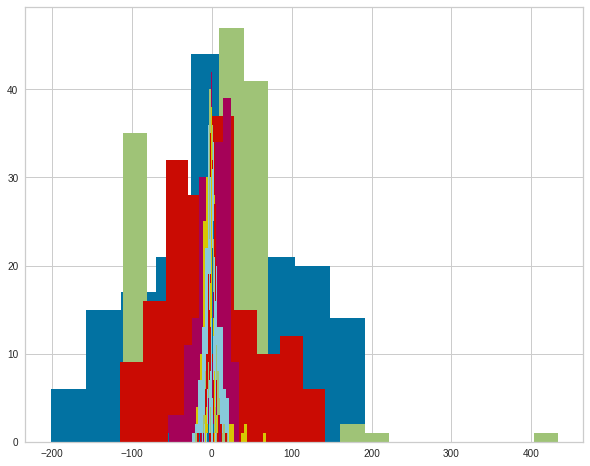

In [6]:
# Plot a histogram to view the data distribution
plt.subplots(figsize =(10, 8))
for col in df_vals.columns:
    plt.hist(df_vals[col], bins='auto')
plt.show()

Most of the data seems to cluster more or less together, however, there does seem to be outliers present. The values after 400 seem to not even be connected to the remaining data. A outlier test will be performed to verify if it needs to be removed.

In [7]:
#Further view data distriution with boxplot
fig = px.box(df_vals)
fig.show()

Once again there do seem to be clear outliers in the data. Additionally, looking at the ranges it also is clear that the data needs to be normalized.

### Correlation

The data will be checked for correlation, as highly correlated features simply causes redundancy. When creating a machine learning model it also is preferable to keep this as simple as possible.

In [8]:
corr_matrix = df_vals.corr(
    method = 'pearson',  # Correlation method
    min_periods = 1      # Min number of observations required
)

# set diagonal to 0.0 to remove self-correlation
# np.fill_diagonal(corr_matrix.values, 0.0)
corr_matrix.head()

0         1         2         3         4         5         6  \
0  1.000000 -0.041708  0.028695 -0.076057  0.013712  0.052373  0.016908   
1 -0.041708  1.000000  0.043172 -0.019783  0.008371  0.008966 -0.003308   
2  0.028695  0.043172  1.000000  0.070564 -0.002763  0.002871  0.008408   
3 -0.076057 -0.019783  0.070564  1.000000  0.013192  0.027493  0.019275   
4  0.013712  0.008371 -0.002763  0.013192  1.000000 -0.004260 -0.007232   

          7         8         9  ...        20        21        22        23  \
0 -0.046053 -0.037217  0.046748  ... -0.028925  0.030022  0.024708 -0.024955   
1 -0.008855 -0.021718  0.012890  ... -0.005368  0.017089 -0.014384  0.001424   
2 -0.008806  0.090029 -0.030186  ...  0.034596 -0.044028  0.031256  0.005013   
3 -0.051065 -0.094024  0.023952  ... -0.051799  0.019674 -0.005013 -0.018987   
4  0.025959 -0.002687  0.011894  ...  0.018083 -0.010714  0.020395  0.015030   

         24        25        26        27        28        29  
0  0.002520  0.019881 -0.018560  0.057024 -0.025943  0.032286  
1 -0.012147 -0.012350 -0.004888  0.020379 -0.024367 -0.007079  
2 -0.011213  0.048836 -0.000353 -0.022921  0.053242  0.035857  
3 -0.025383 -0.059759  0.001855  0.003891  0.005615  0.030173  
4  0.009955  0.014735 -0.003238  0.000607 -0.011486 -0.002767  

[5 rows x 30 columns]

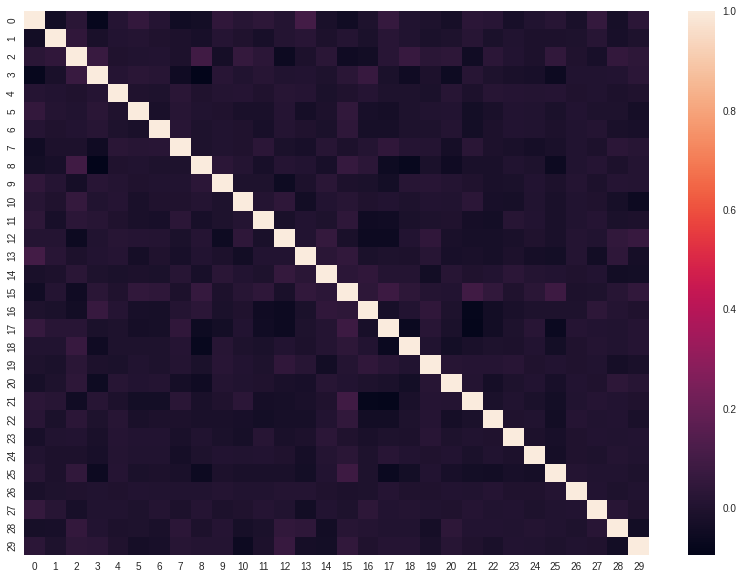

In [9]:
# Visualizing the correlation matrix
plt.subplots(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=False)
plt.show()

The data seems to have almost no correlation, except the diagonal white line. The white line in the middle indicates the self-correlation which obviously is 1. Thus, there is no need to remove features due to high correlation.

### Normality

Another factor that needs to be checked is whether the dataset has a normal distribution. Using the normaltest from scipy.stats, we verify if the data is normally distributed.

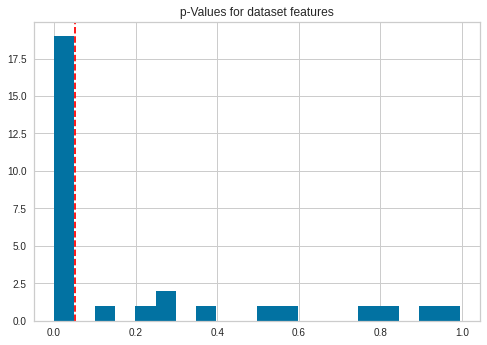

In [10]:
# Perform normality check
s, p = stats.normaltest(df_vals)
plt.hist(p, bins=20)
plt.title('p-Values for dataset features')
plt.axvline(x=0.05, color='red', linestyle='--')
plt.show()

With a p-value higher then the treshold (0.05), the null hypothesis is said to be true, thus the data comes from a normal distribution. A small part of the data however seems to have a value smaller then the treshold, thus not being normally distributed.

## Data pre-processing

Considering the insights gained during the data exploration step, certain steps need to be performed on the data. Outliers have to be removed, data has to be scaled and normalized.

### Outlier removal

In [11]:
def remove_outliers(df,columns,n_std):
    """
    Removes outliers from the dataset that are at least a number of standard deviations away.
    """
    for col in columns:
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

df_filt = remove_outliers(df, df_vals.columns, 2.5)
print(df_filt.shape)

(123, 35)


After removing outliers wich are 2.5 standard deviations away, there were 123 datapoints left. Filtering only on 2 std_dev away, leaves only 80 datapoints which is very little and 3 leaves 151 which might just be too much. Thus a midpoint was chosen, "2.5".

In [12]:
#Further view data distriution with boxplot
fig = px.box(df_filt[df_vals.columns])
fig.show()

According to the above boxplot, the number of outliers is far fewer. Most datapoints now fall within or are much closer to the whiskers.

### Investigating group representation

After excluding outliers, certain species might now be under-represented and will be removed as these no longer give any meaningfull information to the model. Keeping them might also cause classification problems, especially if these entries are outliers for their own groups and there is not enough information to determine this.

In [13]:
# create list with species with less then 5 entries.
val_count = pd.DataFrame(df_filt['Species'].value_counts()).reset_index()
exclude_species = val_count[val_count['Species'] < 5]['index'].tolist()
exclude_species

['mulatta',
 'anubis',
 'gorilla',
 'fuscata',
 'patas',
 'sylvanus',
 'gelada',
 'sphinx',
 'syndactylus',
 'paniscus']

There clearly seem to be severely under-represented species. Having for example just a single entry makes it impossible to properly predict said specie. For this reason, species with less then 5 entries will be removed.

In [14]:
df_filt = df_filt[~df_filt['Species'].isin(exclude_species)]
df_filt.shape

(105, 35)

In [15]:
# Check the number of remaining species
df_filt['Species'].nunique()

13

After filtering the data for outliers and removing under-represented species, there seem to be 105 samples left with 13 unique species.

### Normalization / Scaling

In [16]:
# split dataframe in labels and values
x = df_filt[df_vals.columns]  # values
y = df_filt['Species']  # labels

In [17]:
from sklearn.preprocessing import StandardScaler

def normalize(X):
    scalar = StandardScaler()
    scalar = scalar.fit(X)
    X = scalar.transform(X)
    return pd.DataFrame(X)

X = normalize(x)
X.head()

0         1         2         3         4         5         6   \
0  1.065832 -1.390447  0.319675 -1.155375  1.109435 -0.159395  0.315721   
1  1.196280 -1.493648  0.319577 -1.395462  0.739329 -0.277939  0.213611   
2  1.113408 -1.476969  0.256897 -1.543301  0.853700 -0.695755  1.076115   
3  1.154458 -1.481250  0.239878 -1.525642  0.912057 -0.095716  1.110997   
4  1.163588 -1.321164  0.089374 -0.809057  0.939573  0.291200 -0.515678   

         7         8         9   ...        20        21        22        23  \
0 -1.882424  0.632232  0.179077  ... -0.746262 -0.535231  0.667748 -1.710294   
1 -1.308830 -0.273367 -0.662228  ... -0.197947 -0.720640  0.740048 -1.025517   
2 -0.231659 -0.430879  0.373073  ... -0.606493  1.882064  1.441286 -0.469871   
3 -0.550892 -0.181427 -1.295073  ... -0.124315  1.035728 -0.120255  0.073204   
4 -1.340608 -0.286905 -1.254539  ...  0.201998 -0.270599  0.388134 -0.882389   

         24        25        26        27        28        29  
0  2.100825 -0.366035 -0.731552  0.092139 -0.754382 -1.202851  
1  2.137950  0.417876 -0.490980  1.494808  2.377583 -0.432454  
2 -1.055867 -0.638341 -0.389121 -1.108996 -0.376905  0.228126  
3  0.902736  0.981147 -0.029822 -1.069441 -2.844569  1.536816  
4 -0.573046  1.082569  1.343243  1.681149 -1.071727  2.396824  

[5 rows x 30 columns]

## Dimensionality reduction with t-SNE

t-SNE is a statistical technique used to visualize high-dimensional data in a smaller number of dimensions by using nonlinear dimensionality reduction. Before employing the technique a number of parameters will be optimized so the clusters are separated as well as possible.

In [18]:
#initiate TSNE for 2 dimensions
X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', random_state = 42)
#fit to data
X_embedded = X_embedded.fit_transform(X)
# produced an two dimension array with x,y features for every row, since n_components = 2
X_embedded.shape

(105, 2)

### Perplexity

In [19]:
# define plotting functions needed later.
def plot_cluster(X, df):
    #add x, y features to the original df
    df['x'] = X[:,0]
    df['y'] = X[:,1]
    sns.scatterplot(x = 'x', y = 'y', hue = 'Species', data = df, alpha = 1, palette=sns.color_palette("husl", 13))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()


def plot_sub_cluster(X, df):
    # add x, y features to the original df
    df['x'] = X[:,0]
    df['y'] = X[:,1]
    # create scatterplot using the given parameters
    ax = sns.scatterplot(x = 'x', y = 'y', hue = 'Species', data = df,
                         legend = False, alpha = 0.5, palette=sns.color_palette("husl", 13))
    return ax


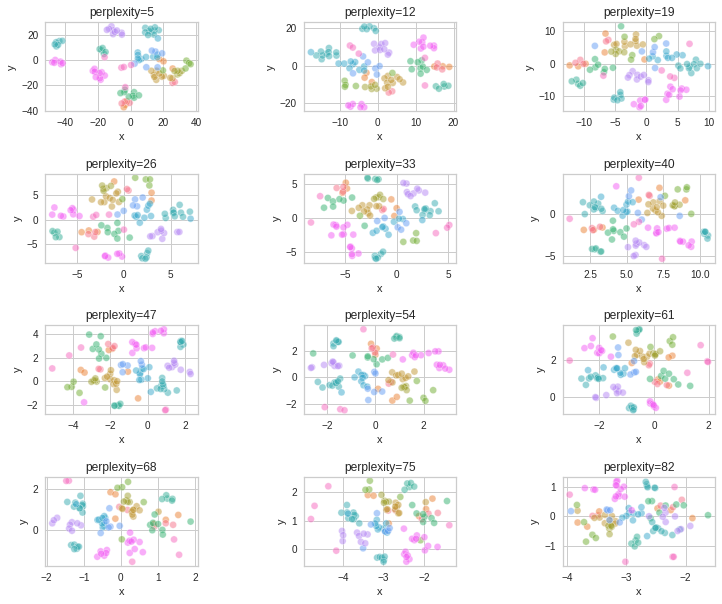

In [20]:
# p = [5, 8, 10, 13, 16, 19, 25, 35, 50]
p = list(range(5, 100, 7))
fig = plt.figure(figsize=(12, 10))
plt.subplots_adjust(wspace=0.7, hspace=0.7)
for i in range(12):
    ax = fig.add_subplot(4, 3, i+1)
    X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity = p[i], random_state = 42)
    X_embedded = X_embedded.fit_transform(X)
    plot_sub_cluster(X_embedded, df_filt)
    ax.set_title(f'perplexity={p[i]}')
plt.show()

The best perplexity ut of the displayed ones seems to be 33, the clusters split decently with very few outliers. It is still however suboptimal but one of the best out of the explored perplexities. The next parameter to be explored will be the method.

### Method

The default method is "barnes hut", however for smaller datasets the "exact" method can be used. This method takes a far longer time to compute and works with getting a nearest-neighbor errors better than 3%.

In [21]:
#initiate instance
X_embedded = TSNE(n_components=2, 
                  learning_rate='auto', 
                  perplexity = 33, 
                  method='exact', 
                  random_state = 42, 
                  init='random')
#fit 
X_embedded = X_embedded.fit_transform(X)
# produced an two dimension array with x,y features for every row, since n_components = 2
X_embedded.shape

(105, 2)

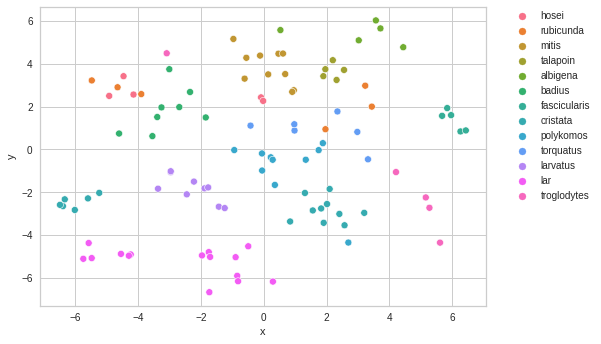

In [22]:
plot_cluster(X_embedded, df_filt)

The clusters clearly seem to be becoming more accurate. There still are some outliers but most of the values are in a well outlined cluster.

### number of iterations
The last parameter to be explored is the number of iterations. For the optimization of the clustering t-SNE iterates several times over the data. This is usually at least 250.

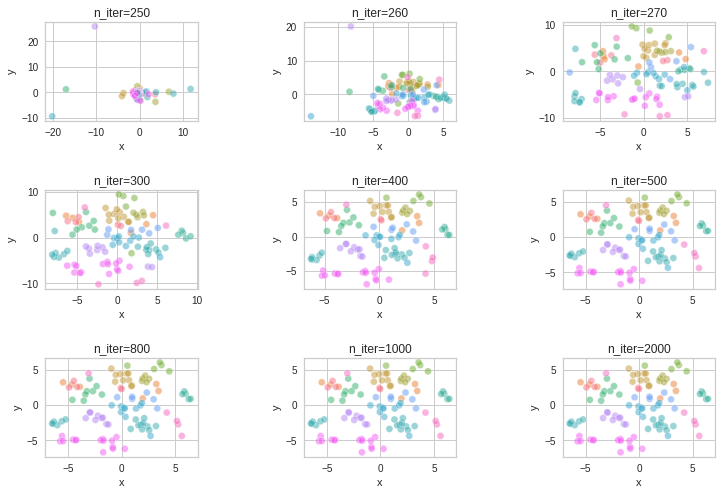

In [23]:
p = [250, 260, 270, 300, 400, 500, 800, 1000, 2000]
fig = plt.figure(figsize=(12, 8))
plt.subplots_adjust(wspace=0.7, hspace=0.7)
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', 
                      perplexity = 33, 
                      random_state = 42, 
                      method = 'exact',
                      n_iter = p[i])
    X_embedded = X_embedded.fit_transform(X)
    plot_sub_cluster(X_embedded, df_filt)
    ax.set_title(f'n_iter={p[i]}')
plt.show()

It seems that at about 500 iterations, the clustering no longer changes. This likely means that after 500 the t-SNE has reached it best and won't change much more.

In [24]:
# Create the optimal model
X_embedded_opt = TSNE(n_components=2, learning_rate='auto', init='random', 
                      perplexity = 33, 
                      random_state = 42, 
                      method = 'exact',
                      n_iter = 500)
X_embedded_opt = X_embedded_opt.fit_transform(X)

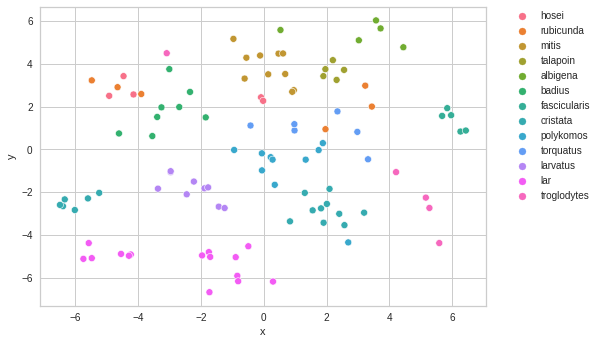

In [25]:
plot_cluster(X_embedded_opt, df_filt)

## Creating a model

### K-Means Clustering

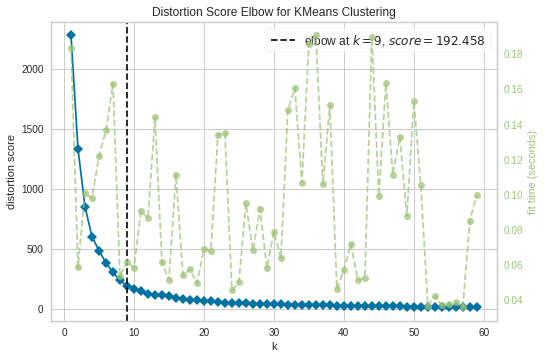

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
kmeans = KMeans(init='random', n_clusters=13, random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(1,60)).fit(X_embedded_opt)
visualizer.show()

The above elbow plot is very clear and shows that the embedded data has around 9 clusters. This is quite close to the number of remaining unique species, which is 13. Considering the location of the elbow, it could even be argumented that 13 might also be a candidate for creating the model.

In [27]:
features = pd.DataFrame(X_embedded_opt)  # name scaled features
kmeans = KMeans(init="random",n_clusters=13,n_init=10,max_iter=300,random_state=42)
kmeans.fit(features)
features['cluster'] = kmeans.predict(features)

In [28]:
embedding = MDS(n_components=2)  # reduce to 2 components
mds = pd.DataFrame(embedding.fit_transform(features.drop('cluster',axis=1)),
             columns = ['component1','component2'])
mds['cluster'] = kmeans.predict(features.drop('cluster',axis=1))
mds['true_labels'] = pd.DataFrame(y).values

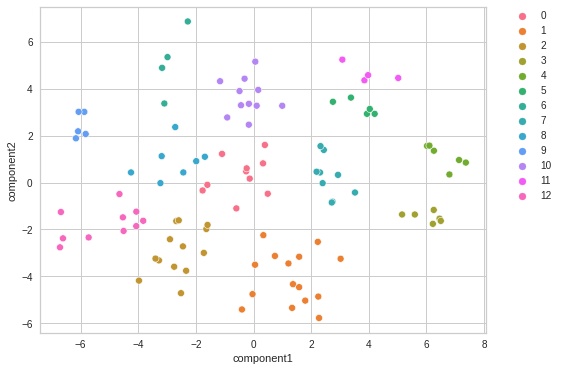

In [29]:
# plot the data using the number of clusters and actual labels
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=mds, x = "component1", y="component2", hue="cluster", palette=sns.color_palette("husl", 13))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

In [30]:
kmns = KMeans(init="random",n_clusters=13,n_init=10,max_iter=300,random_state=42)
kY = kmns.fit_predict(mds[['component1', 'component2']])

metrics.adjusted_rand_score(kY, mds['true_labels'])

0.5546702748029612

The groups seem to be decently well divided, however still suboptimal (as can be seen through the score). Perhaps a different clustering algorithm might be able to better take care of this embedded dataset.

### DBScan

Density-based spatial clustering of applications with noise (DBScan) is a algorithm that performs clustering based on "density" of the points. Points lying close together are made into a cluster based on a number of parameters. The most important parameters are "eps" (distance to be considered neighbors and MinPts (minimum numer of neigbors, usually n+1, where n is number of dimensions).

In [31]:
# Since the embedding has been done to 2 dimensions, the value of 3 will be used.
nbrs = NearestNeighbors(n_neighbors=3).fit(X_embedded_opt)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(X_embedded_opt)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)

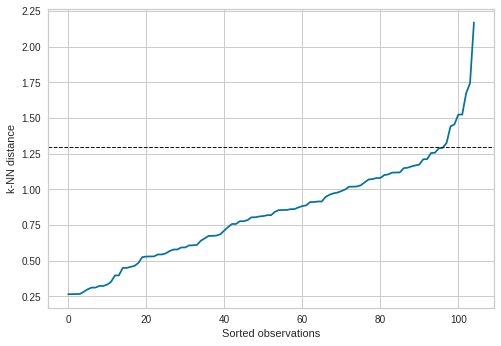

In [32]:
k_dist = sort_neigh_dist[:, 2]
plt.plot(k_dist)
plt.axhline(y=1.3, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations")
plt.show()

In the k-NN distance plot, one looks for the “knee” of the curve to find the optimal value of ε. In this case that seems to be a value close to 1.25. When instanciating DBScan, a value of 1.3 will be used.

In [33]:
clusters = DBSCAN(eps=1.3, min_samples=4).fit(X_embedded_opt)
# get cluster labels
clusters.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  2,  2,  2,  2,  2,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,
        4,  4,  4, -1, -1, -1, -1, -1,  5,  5,  5,  5,  5,  5,  6,  6,  6,
        6,  6,  6])

In [34]:
# check unique clusters
set(clusters.labels_)
# -1 value represents noisy points could not assigned to any cluster
Counter(clusters.labels_)
# Convert to df otherwise sns won't plot it properly
tsne_em_df = pd.DataFrame(X_embedded_opt, columns=["t-SNE-1", "t-SNE-2"])

In [35]:
# Assign predicted and true labels
tsne_em_df['predicted'] = pd.Series(clusters.labels_)
tsne_em_df['true_labels'] = pd.Series(y).values

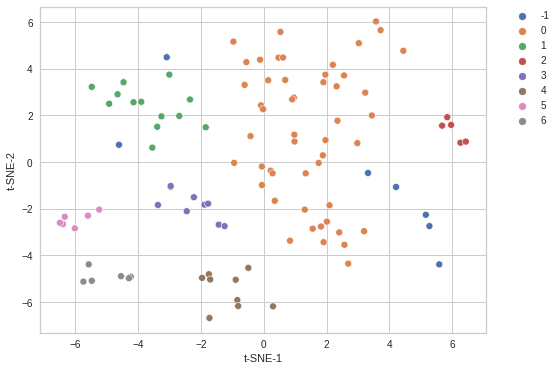

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=tsne_em_df, x="t-SNE-1", y="t-SNE-2",
                hue=clusters.labels_, legend="full", palette="deep")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

In [37]:
dbs = DBSCAN(eps=1.3, min_samples=4).fit_predict(tsne_em_df[['t-SNE-1','t-SNE-2']])
metrics.adjusted_rand_score(dbs, tsne_em_df['true_labels'])

0.23861366267439868

DBScan also seems to be able to find clusters in the data. However, as some points lie closer together, several groups are determined as a single group. Considering the score of about 0.24, this algorithm most certainly is not a good fit for this data.

## Chosen algorithm

The model that seems to do best with this data is k-means clustering. On visual inspection it seems to form clear groups and it has the better score out of the two tested algorithms. To improve this model hyperparameter tuning will be performed.

## Hyperparameter tuning

In [38]:
# Create variables for quick use
x = mds[['component1', 'component2']]
y = mds['true_labels']

### Init

Init changes how to clusters are selected during the initialization. There are only two parameters to be tested.

In [39]:
#  check optimal init
def init_checker(variables, x, y):
    score_dict = {}
    for i in variables:
        kmns = KMeans(init=str(i),n_clusters=13,n_init=10,max_iter=300,random_state=42)
        kY = kmns.fit_predict(x)
        score_dict[i] = metrics.adjusted_rand_score(kY, y)
    return score_dict

inits = ['k-means++', 'random']
init_checker(inits, x, y)

{'k-means++': 0.5907780903594778, 'random': 0.5546702748029612}

'k-means++' seems to perform better then 'random' and will thus be selected.

### Number of Init

The number of times the k-means algorithm runs with different centroid seeds.

In [40]:
#  check optimal number of inits
def n_init_checker(variables, x, y):
    score_list = []
    for i in variables:
        kmns = KMeans(init='k-means++',n_clusters=13,n_init=i,max_iter=300,random_state=42)
        kY = kmns.fit_predict(x)
        score_list.append(metrics.adjusted_rand_score(kY, y))
    return score_list

n_inits = range(1, 31)
n_inits_list = n_init_checker(n_inits, x, y)

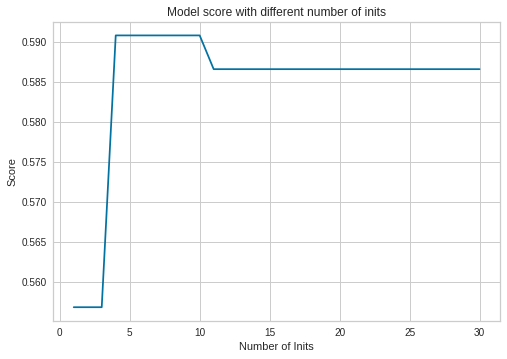

In [41]:
plt.plot(n_inits, n_inits_list)
plt.title('Model score with different number of inits')
plt.xlabel('Number of Inits')
plt.ylabel('Score')
plt.show()

The score related to the number of inits steeply increases and reaches a maximum at around 4-9. Afterwards it starts decreasing. Thus 5 will be chosen to create the optimized model. 

### Max iterations

Maximum number of iterations the algorithm will run.

In [42]:
#  check optimal init
def max_iter_checker(variables, x, y):
    score_list = []
    for i in variables:
        kmns = KMeans(init='k-means++',n_clusters=13,n_init=5,max_iter=i,random_state=42)
        kY = kmns.fit_predict(x)
        score_list.append(metrics.adjusted_rand_score(kY, y))
    return score_list

max_iter = range(100, 500)
max_iter_list = max_iter_checker(max_iter, x, y)

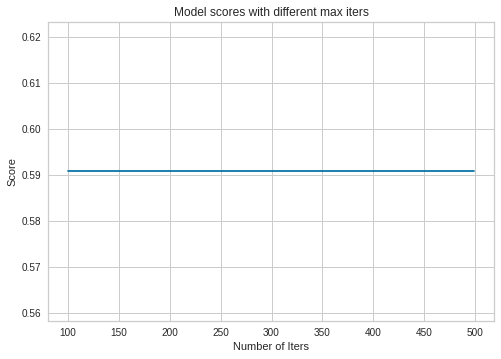

In [43]:
plt.plot(max_iter, max_iter_list)
plt.title('Model scores with different max iters')
plt.xlabel('Number of Iters')
plt.ylabel('Score')
plt.show()

The number of iterations does not seem to change anything about the accuracy and will be left at 300.

### Algorithms

There are different algorithms available for this model and the scores will be calculated to observe the best.

In [44]:
#  check optimal init
def algorithm_checker(algoritms, x, y):
    score_dict = {}
    for i in algoritms:
        kmns = KMeans(init='k-means++',n_clusters=13,n_init=5,max_iter=300,random_state=42, algorithm=i)
        kY = kmns.fit_predict(x)
        score_dict[i] = metrics.adjusted_rand_score(kY, y)
    return score_dict

algorithms = ['auto', 'full', 'elkan']
algorithms_scores_dict = algorithm_checker(algorithms, x, y)
algorithms_scores_dict

{'auto': 0.5907780903594778,
 'full': 0.5907780903594778,
 'elkan': 0.5907780903594778}

There does not seem to be a optimal algorithm, as they all score equally. This is quite strange, however they might all be similar and this data does not allow them to excel at their differences. The default algorithm will be used for this model.

## Final visualization

In [45]:
features = pd.DataFrame(x)  # name scaled features
kmeans = KMeans(init="random",n_clusters=13,n_init=10,max_iter=300,random_state=42)
kmeans.fit(features)
features['cluster'] = kmeans.predict(features)

In [46]:
embedding = MDS(n_components=2)  # reduce to 2 components
mds = pd.DataFrame(embedding.fit_transform(features.drop('cluster',axis=1)),
             columns = ['component1','component2'])
mds['cluster'] = kmeans.predict(features.drop('cluster',axis=1))
mds['true_labels'] = pd.DataFrame(y).values

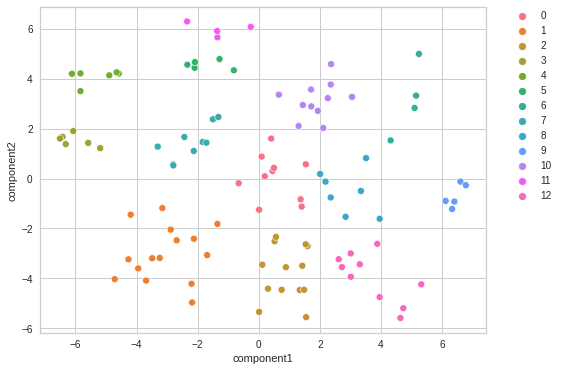

In [47]:
# plot the data using the number of clusters and actual labels
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=mds, x = "component1", y="component2", hue="cluster", palette=sns.color_palette("husl", 13))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

After hyperparameter tuning, the clustering seems to have improved slightly compared to beforehand. However, it is still clearly sub-optimal with an accuracy of about 60%.

## Conclusion

Out of the tested clustering algorithms, t-SNE seems to perform best with this data decently creating clusters for each species, however these do all lie close together and even after optimizing hyperparameters, misclassification happens often.

The largest problem when training the model with this dataset was the very small number of samples. This woudn't be a very large issue is there were only 2 or 3 groups, however the large number of groups contibutes to a poor representation of each species. Removing the most under-represented species partially mitigates this issue allowing the model to better distinguish the remaining groups. Keeping the misrepresented species just increased the noise in the dataset leading to less accurate clustering.

Finally, the quality of a dataset is very important for creating a model. The saying goes "garbage in, garbage out", this is not to say that a sub-optimal dataset cannot be used but that only so much can be done to optimize it, as seen with this dataset. After cleaning the data and training the model it is able to cluster the data and classifies the datapoints with an accuracy of about 60%.